In [330]:
# Import of the packages
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import math
import scipy.stats as sts

In [177]:
# SVM classifier
class SVM:
    """ Support Vector Machine (SVM).
    
    Constructor to initialize the SVM with the different desired
    parameters and the type of SVM.
    
    Attributes:
        kerType: A string of the type of desired kernel.
        svmType: A string of the type of desired SVM.
        V: V-variable.
        C: C-variable.
        p: Degree of the polynomial kernel.
        sigma: Smoothing factor the Gaussian kernel.
        kappa: Scaling parameter of the sigmoid kernel.
        delta: Translation parameter of the sigmoid kernel.
        eps: Size of the insensitive tube.
    """

    EPSILON = 1e-5
    
    def __init__(self, kerType = 'poly', svmType = 'C',
                 V = 0.45, C = 1, p = 1, sigma = 1, 
                 kappa = 1, delta = 1, eps = 0.5):
        """ Initializes the SVM class."""
    
        
        self.kerType = kerType
        self.svmType = svmType
        self.V = V
        self.C = C
        self.p = p
        self.sigma = sigma
        self.kappa = kappa
        self.delta = delta
        self.eps = eps
    
    def kernel(self, x, y):
        """ Kernel computation.
        
        It computes the kernel value based on the dot product
        between two vectors.
        
        Args:
            x: Input vector.
            y: Other input vector.
            
        Returns:
            Kernel computation.
        """
        
        if self.kerType == "linear":
            k = np.dot(x,y) + 1
        elif self.kerType == "poly":
            k = (np.dot(x,y) + 1) ** self.p
        elif self.kerType == "radial":
            k = math.exp(-(np.dot(x-y,x-y))/(2*self.sigma))
        elif self.kerType == "sigmoid":
            k = math.atanh(self.kappa * np.dot(x,y) - self.delta)

        return k
    
    def lagrange(self, params, X, y, K):
        """
        TO DO
        """
        N2 = np.shape(params)[0]
        N = int(N2/2)
        a = params[0:N].reshape((N,1))
        a_hat = params[N:N2].reshape((N,1))
        y = y.reshape((N,1))
        if self.svmType == "C":
            L = (1/2) * (a - a_hat).T.dot(K).dot(a - a_hat) \
                + self.eps * np.sum(a + a_hat) \
                - (a - a_hat).T.dot(y)
        elif self.svmType == "V":
            L = (1/2) * (a - a_hat).T.dot(K).dot(a - a_hat) \
                    - (a - a_hat).T.dot(y)
        return L
    
    def train(self, X_tr, Y_tr):
        """TO DO"""
        N_tr = np.shape(X_tr)[0]
        K = np.zeros((N_tr, N_tr))
        for i in range(N_tr):
            for j in range(N_tr):
                K[i,j] = self.kernel(X_tr[i], X_tr[j])
        args = (X_tr, Y_tr, K)
        
        bounds = []
        if self.svmType == "C":
            for i in range(0, 2*N_tr):
                bounds.append((0,self.C))
        elif self.svmType == "V":
            for i in range(0, 2*N_tr):
                bounds.append((0,self.C / N_tr))
        
        def constraint_a(params):
            N2 = np.shape(params)[0]
            N = int(N2/2)
            a = params[0:N]
            a_hat = params[N:N2]
            return np.sum(a - a_hat)
        
        def constraint_b(params):
            N2 = np.shape(params)[0]
            N = int(N2/2)
            a = params[0:N]
            a_hat = params[N:N2]
            return self.V * self.C - np.sum(a + a_hat)

        if self.svmType == "C":
            cons = {'type':'eq', 'fun': constraint_a}
        elif self.svmType == "V":
            cons = [{'type':'eq', 'fun': constraint_a},
                {'type':'ineq', 'fun' : constraint_b}]

        
        initial = np.zeros(2*N_tr)
        final = optimize.minimize(self.lagrange, initial, args, \
            bounds=bounds, constraints=cons, method='SLSQP')
        
        if final.success != True:
            # exception shit
            print(final.success)
            return
        
        a = final.x[0:N_tr]
        a_hat = final.x[N_tr:2*N_tr]
        
        
        for i in range(N_tr):
            if (a[i] < self.C and a[i] > 0):
                yn = Y_tr[i]
                ind = i
                break

        b = yn - self.eps - (a - a_hat).T.dot(K)[ind]
        
        cond_valuable = abs((a - a_hat)) > self.EPSILON
        a = a[cond_valuable]
        a_hat = a_hat[cond_valuable]
        X_sv = X_tr[cond_valuable]
        Y_sv = Y_tr[cond_valuable]
        
        self.a = a
        self.a_hat = a_hat
        self.b = b
        self.X_sv = X_sv
        self.Y_sv = Y_sv
        
    def pred(self, X):
        """ TO DO """
        
        N_sv = np.shape(self.X_sv)[0]
        N = np.shape(X)[0]
        a = self.a.reshape(N_sv,1)
        a_hat = self.a_hat.reshape(N_sv,1)
        K = np.zeros((N_sv, N))
        for i in range(N_sv):
            for j in range(N):
                K[i,j] = self.kernel(self.X_sv[i],X[j])
        y = (a - a_hat).T.dot(K) + self.b
        y = y.reshape(-1)
        return y
    
    def getSV(self):
        return self.X_sv, self.Y_sv

In [178]:
N_tr = 10
N_ts = 100

def trans(x):
    N = np.shape(x)[0]
    y = np.sin(x) + 3 + np.random.normal(loc=0, scale=0.1, size=N)
    return y 

x_tr = np.linspace(0,7.5,num=N_tr)
y_tr = trans(x_tr)
x_ts = np.linspace(0,7.5,num=N_ts)
y_ts = trans(x_ts)

In [179]:
s = SVM(kerType="radial", C = 10, p = 5, sigma = 1, eps = 0.1)
s.train(X_tr=x_tr, Y_tr=y_tr)
y_pred = s.pred(x_ts)

In [180]:
def printTest(X,Y,X_tst,Y_tst,X_sv,Y_sv,eps):
    plt.plot(X,Y,'ko')
    plt.plot(X_tst, Y_tst, 'b')
    plt.fill_between(X_tst, Y_tst-eps, Y_tst+eps, \
        facecolor='lightblue', interpolate=True, alpha=0.5)
    plt.plot(X_sv, Y_sv, 'go')
    plt.legend(['Not SV', \
                'Regression', \
                'SV', \
                'Insensitive tube'])
    plt.show()

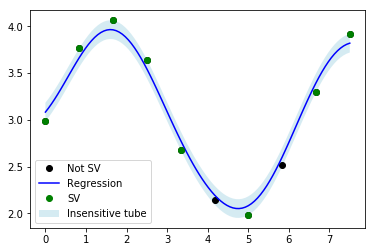

In [181]:
x_sv, y_sv = s.getSV()
printTest(x_tr,y_tr,x_ts,y_pred,x_sv,y_sv,0.1)